In [36]:
# sys
import os
# data structures
import pandas as pd
# Computation
import numpy as np
# Visualization
import seaborn as sb
import matplotlib.pyplot as plt
import bokeh
# OWN
import py_to_psql as pp
import psycopg2 as p

# Functions

In [37]:
def missing_val_df(
    df, 
    drop_cols,
    cols=["Non-Null Count", "% of no nulls", "Dtype"] 
    ):
    mv_df = pd.DataFrame(
        data=[
            df.count(), 
            (df.count()*100/df.count().max()).round(2), 
            df.dtypes
        ]
    ).transpose()
    mv_df.columns = cols
    return mv_df.drop(index=drop_cols)

# Statistical Analysis

## Original filtered-unnested data with no seismic

### DataFrames from csv

In [38]:
csv_path = os.getcwd() + os.path.join("\\Filtered_data") 
sliced_litho_logs_df = pd.read_csv(
    csv_path + os.path.join("\\sliced_litho_logs.csv")
)
sliced_logs = pd.read_csv(
    csv_path + os.path.join("\\sliced_logs.csv")
)
sliced_litho = pd.read_csv(
    csv_path + os.path.join("\\sliced_litho.csv")
)
dropped_wells = [
    '41/10- 1', '41/10a- 2Z', '41/14- 1', '41/15- 1', '41/20- 1', '41/25a- 1',
    '42/16- 1', '42/18- 2','42/21- 1', '42/22- 1', 
    '43/03- 1', '43/05- 1', 
    '44/12- 1'
]
# Dropping wells
sliced_litho_logs_df = sliced_litho_logs_df[~sliced_litho_logs_df.well_name.isin(dropped_wells)]
sliced_logs = sliced_logs[~sliced_logs.well_name.isin(dropped_wells)]
sliced_litho = sliced_litho[~sliced_litho.well_name.isin(dropped_wells)]

C:\Program Files\OpendTect\Python\envs\odmlpython-cpu-mkl\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
sliced_litho_logs_df.tail(8)

,index,well_name,md_in_m,gr,dtco,dtsh,rhob,nphi,drho,pef,...,top_down_hole_depth_m,hc_present,litho_1,pct_litho_1,litho_2,pct_litho_2,litho_3,pct_litho_3,litho_4,pct_litho_4
93455,101688.0,39/11- 1,2757.2695,27.0605,69.8867,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93456,101689.0,39/11- 1,2757.4221,25.9920,68.5314,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93457,101690.0,39/11- 1,2757.5744,27.1553,67.0432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93458,101691.0,39/11- 1,2757.7268,27.8079,65.6389,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93459,101692.0,39/11- 1,2757.8791,28.3627,65.1772,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93460,101693.0,39/11- 1,2758.0314,28.8106,65.5089,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93461,101694.0,39/11- 1,2758.1840,28.9700,66.5535,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93462,101695.0,39/11- 1,2758.3364,28.4617,66.8492,NaN,NaN,NaN,NaN,NaN,...,2758.44,NaN,CLST,50.0,SLST,50.0,NaN,0.0,NaN,0.0


### Empty Values

In [40]:
sliced_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93463 entries, 0 to 93462
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  93463 non-null  int64  
 1   well_name   93463 non-null  object 
 2   md_in_m     93463 non-null  float64
 3   gr          93463 non-null  float64
 4   dtco        91572 non-null  float64
 5   dtsh        0 non-null      float64
 6   rhob        56753 non-null  float64
 7   nphi        49453 non-null  float64
 8   drho        47935 non-null  float64
 9   pef         34567 non-null  float64
 10  md_round2   93463 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 8.6+ MB


In [41]:
missing_val_df(sliced_logs, ["Unnamed: 0", "md_round2"])

,Non-Null Count,% of no nulls,Dtype
well_name,93463,100.0,object
md_in_m,93463,100.0,float64
gr,93463,100.0,float64
dtco,91572,97.98,float64
dtsh,0,0.0,float64
rhob,56753,60.72,float64
nphi,49453,52.91,float64
drho,47935,51.29,float64
pef,34567,36.98,float64


The amount of samples in each log is presented in the previous output. From the 98 wells in the survey, only 20 wells are suitable for further analysis because they:
1. Prospects the selected interval. All these wells contain information between the chosen markers: Top Zechstein, Top Rotliegend(es) and Base Rotliegend(es).
2. At least contains two logs that sample the interval mentioned above   
    
After slicing data from these 20 wells in the chosen interval, 93.463 samples of petrophysical data could be collected. Of these 93.463 samples at depth in different wells:
- 93.463 (100%) are sampled by GR,
- 91.572 (97.98%) by DTCO,
- 0 (0%) by DTSH,
- 56.753  (60.72%) by RHOB,
- 47.935 (51.29%) by DRHO,
- 49.595 (52.91%) by NPHI,
- 34.567 (36.98%) by PEF.
    
It is clear that less than the 50% of the data is sampled by the main records. Unfortunately, 0% is sampled by the shear-wave log. Although interpretations can be done using this quantity of data, it could be possible to improve those percentages by predicting logs using the ones with the biggest quentity of data and Supervised Machine Learning algorithms. Further analysis must be done to compare whether this predictions correlate with the existing logs and their linear and statistical behavior with respect to the originals.

In [42]:
sliced_litho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             106 non-null    int64  
 1   well_name              106 non-null    object 
 2   top_down_hole_depth_m  106 non-null    float64
 3   upper_litho            105 non-null    object 
 4   upper_chrono           106 non-null    object 
 5   litho_1                99 non-null     object 
 6   pct_litho_1            106 non-null    float64
 7   litho_2                69 non-null     object 
 8   pct_litho_2            106 non-null    float64
 9   litho_3                35 non-null     object 
 10  pct_litho_3            106 non-null    float64
 11  litho_4                9 non-null      object 
 12  pct_litho_4            106 non-null    float64
 13  hc_present             16 non-null     object 
 14  md_round2              106 non-null    float64
dtypes: flo

In [43]:
missing_val_df(sliced_litho, [
    "Unnamed: 0", "md_round2",
    "top_down_hole_depth_m",
    "upper_litho", "upper_chrono",
    "pct_litho_1", "pct_litho_2", "pct_litho_3", "pct_litho_4"
])

,Non-Null Count,% of no nulls,Dtype
well_name,106,100.0,object
litho_1,99,93.4,object
litho_2,69,65.09,object
litho_3,35,33.02,object
litho_4,9,8.49,object
hc_present,16,15.09,object


In [44]:
litho1_no_nans_df = sliced_litho_logs_df[~sliced_litho_logs_df['litho_1'].isnull()]
# litho1_no_nans_df.drop(
#     columns=[
#         "index",
#         "md_round2_x", "md_round2_y",
#         "litho_3", "pct_litho_3",
#         "litho_4", "pct_litho_4"
#     ]).info()

In [45]:
missing_val_df(
    litho1_no_nans_df,
    [
        "index",
        "md_round2_x", "md_round2_y", "top_down_hole_depth_m",
        "pct_litho_1", "pct_litho_2", "pct_litho_3", "pct_litho_4"
    ]
)

,Non-Null Count,% of no nulls,Dtype
well_name,94,100.0,object
md_in_m,94,100.0,float64
gr,94,100.0,float64
dtco,92,97.87,float64
dtsh,0,0.0,float64
rhob,80,85.11,float64
nphi,76,80.85,float64
drho,73,77.66,float64
pef,50,53.19,float64
hc_present,16,17.02,object


The last .info() corresponds to the litho_log_df where any row without litho_1 information has been dropped. Note that, in this particular case:
- 94 (100%) are sampled by GR,
- 92 (97.87%) by DTCO,
- 0 (0%) by DTSH,
- 80 (85.11%) by RHOB,
- 73 (77.66 %) DRHO,
- 76 (80.85%) by NPHI,
- 73 (53.19 %) by PEF.
    
This Dataframe contains enough information to develop a mathematical model for lithological prediction. At least, 81% of samples contains information of the main logs. Unfortunately, DTSH doesn't contain any information that could be used.

### Statistical Analysis

### Rapid Statistical Parameters with pandas.describe

In [47]:
sliced_logs.drop(columns="md_round2").describe()

,Unnamed: 0,md_in_m,gr,dtco,dtsh,rhob,nphi,drho,pef
count,93463.000000,93463.000000,93463.000000,91572.000000,0.0,56753.000000,49453.000000,47935.000000,34567.000000
mean,51851.555878,2047.652161,34.846887,71.561545,NaN,2.330916,0.178619,0.002442,4.037430
std,30405.132558,835.004876,34.461060,14.808761,NaN,0.342400,0.164903,0.021111,1.216245
min,0.000000,442.631700,2.066800,-137.649800,NaN,1.214000,-0.027900,-0.127400,1.725900
25%,23365.500000,1260.652800,9.987800,66.900000,NaN,2.136700,0.020400,-0.009300,3.225200
50%,54943.000000,2264.257000,21.844200,68.208700,NaN,2.379000,0.174300,-0.001500,4.032500
75%,78318.500000,2605.810750,47.216450,75.760100,NaN,2.546100,0.243500,0.008800,4.639100
max,101695.000000,3994.861000,257.327200,226.372500,NaN,3.027300,0.724300,0.227000,23.062500


Rapid statistics allows to precise problems in the samples:
- The first two columns are not relevant in a statistical way because index and depth (due to spatial variability) are not directly associated with HC content or lithology.
- GR seems to be affected by a big positive outlier. Note a maximum of 257.3272 gr with a mean of 34.85. Percentile 75% show values around 47.22, so it is highly possible that outlier doesn't correspond to a geological feature.
- DTCO shows a minimum (-137.65) that is highly possible to be an error. Slowness samples can't be negative. Moreover, an outlier of 226.37 could be present and its behavior is similar with the one discussed in GR.
- DTSH's is nan.
- RHOB's statistical parameters seems to be within the standard scale of rock densities. However, the minimum of 1.21 should be inspected. Although 1.21 g/cm3 exist in rock density scale, the value should be confronted against MD and other parameters to see whether it has geological meaning.
- Among all the logs, NPHI has the most outstanding and geological impossible outlier. Beyond the outlier, statistical parameters seems to be OK if it weren't for negative values as minimums.


In [8]:
litho1_no_nans_df.drop(
    columns=[
        "index",
        "md_round2_x", "md_round2_y",
        "litho_3", "pct_litho_3",
        "litho_4", "pct_litho_4"
    ]).describe(include="all")

,well_name,md_in_m,gr,dtco,dtsh,rhob,nphi,top_down_hole_depth_m,hc_present,litho_1,pct_litho_1,litho_2,pct_litho_2
count,94,94.000000,94.000000,92.000000,0.0,80.000000,76.000000,94.000000,16,94,94.000000,66,94.000000
unique,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,14,NaN,13,NaN
top,26/14- 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GS,ANHY,NaN,ANHY,NaN
freq,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,22,NaN,21,NaN
mean,NaN,1787.717479,50.665684,69.440838,NaN,2.525095,0.147032,1787.716489,NaN,NaN,80.117021,NaN,15.202128
std,NaN,835.950820,35.803977,17.343408,NaN,0.308993,0.121318,835.952424,NaN,NaN,20.132281,NaN,15.932370
min,NaN,442.631700,8.485100,49.003300,NaN,1.273400,-0.019800,442.510000,NaN,NaN,30.000000,NaN,0.000000
25%,NaN,1095.918775,26.722225,62.273625,NaN,2.447575,0.046225,1095.975000,NaN,NaN,60.000000,NaN,0.000000
50%,NaN,1483.706750,41.192800,66.480900,NaN,2.561550,0.139150,1483.765000,NaN,NaN,90.000000,NaN,10.000000
75%,NaN,2555.290700,63.805475,72.188775,NaN,2.732600,0.225100,2555.290000,NaN,NaN,100.000000,NaN,30.000000


More parameters are shown:
- 19 unique wells are included along the 94 samples.
- Only 15 samples are directly associated with HC content. There are two possibilities: GAS SHOWS, which are the majority and OIL SHOWS.
- There are 14 unique lithologies in litho_1. Among these, the most common is ANHY
- pct_litho_1 mean is over 80%, which indicate that litho_1 fully characterizes, on its own, at least 80% of the samples thus it has substantial predictive power.
- litho_2 only characterizes at least 15% of the samples. Not a great value, but could complement litho_1.
- Logs still contain outliers, mostly at maximum and post 75 perceptile.
- NPHI still has a negative value as the nimimum.

In [11]:
litho1_no_nans_df[~litho1_no_nans_df['hc_present'].isnull()]

,index,well_name,md_in_m,gr,dtco,dtsh,rhob,nphi,md_round2_x,md_round2_y,top_down_hole_depth_m,hc_present,litho_1,pct_litho_1,litho_2,pct_litho_2,litho_3,pct_litho_3,litho_4,pct_litho_4
8733,8733.0,26/07- 1,1071.9652,46.4456,54.5089,NaN,2.8178,0.0822,1071.97,1072.04,1072.04,OS,LMST,85.0,MDST,10.0,ANHY,5.0,NaN,0.0
17124,17124.0,26/14- 1,512.0638,39.1888,97.6240,NaN,2.4746,0.3872,512.06,512.06,512.06,GS,ANHY,90.0,CLST,5.0,SDST,5.0,NaN,0.0
17292,17292.0,26/14- 1,520.5982,26.1424,81.2507,NaN,2.2344,0.1674,520.60,520.60,520.60,GS,HALI,60.0,SYLV,15.0,CARN,15.0,ANHY,10.0
20130,20130.0,26/14- 1,664.7685,14.4218,68.8748,NaN,2.0761,-0.0079,664.77,664.77,664.77,GS,ANHY,70.0,HALI,30.0,NaN,0.0,NaN,0.0
20358,20358.0,26/14- 1,676.3509,40.0620,67.1248,NaN,2.2109,0.0048,676.35,676.35,676.35,GS,CLST,80.0,ANHY,20.0,NaN,0.0,NaN,0.0
20418,20418.0,26/14- 1,679.3989,37.5632,67.6249,NaN,2.1835,0.1035,679.40,679.40,679.40,GS,HALI,70.0,CARN,20.0,SYLV,10.0,NaN,0.0
24888,24888.0,26/14- 1,906.4748,64.0733,63.6243,NaN,2.5038,0.1938,906.47,906.48,906.48,GS,ANHY,60.0,HALI,30.0,DOLO,10.0,NaN,0.0
25212,25212.0,26/14- 1,922.9340,17.7960,55.3769,NaN,2.5916,0.0122,922.93,922.93,922.93,GS,DOLO,60.0,ANHY,30.0,LMST,10.0,NaN,0.0
25632,25632.0,26/14- 1,944.2700,31.3459,71.1232,NaN,2.6327,0.2397,944.27,944.27,944.27,GS,ANHY,100.0,NaN,0.0,NaN,0.0,NaN,0.0
25674,25674.0,26/14- 1,946.4036,34.9896,66.4990,NaN,2.2773,0.0082,946.40,946.40,946.40,GS,CARN,40.0,HALI,35.0,SYLV,25.0,NaN,0.0


### Identifying anomalous data

In [9]:
print(sliced_logs[sliced_logs["rhob"] >= 3].to_string())

       Unnamed: 0 well_name    md_in_m       gr     dtco  dtsh    rhob    nphi  md_round2
488           488  20/12- 2  3512.5151   8.7109  51.1250   NaN  3.0059  0.0048    3512.52
490           490  20/12- 2  3512.8200   8.0938  51.3750   NaN  3.0019  0.0004    3512.82
494           494  20/12- 2  3513.4296   9.0859  50.7500   NaN  3.0000  0.0004    3513.43
495           495  20/12- 2  3513.5820   7.8242  50.0000   NaN  3.0137  0.0014    3513.58
497           497  20/12- 2  3513.8867   6.8750  53.1250   NaN  3.0195 -0.0010    3513.89
498           498  20/12- 2  3514.0393   5.7031  52.0000   NaN  3.0195 -0.0015    3514.04
499           499  20/12- 2  3514.1916   7.2109  51.7500   NaN  3.0273  0.0004    3514.19
500           500  20/12- 2  3514.3439   7.2109  51.3750   NaN  3.0019  0.0034    3514.34
2500         2500  20/12- 2  3819.1440  13.2031      NaN   NaN  3.0000 -0.0030    3819.14
2501         2501  20/12- 2  3819.2963  11.9062      NaN   NaN  3.0000 -0.0025    3819.30
50925     

### Visual Statistics

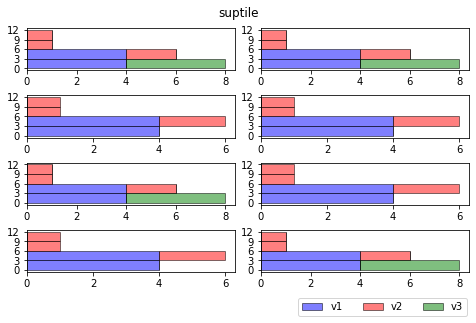

In [71]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

v1=[3,1.1,2,5.2,4.9,2.6,3,0.5]
v2=[6.1,5.2,9.5,4.5]
v3=[0.1,1.4,0.5,1.2]

fig, axes = plt.subplots(4,2, figsize=(6.5,4.0), constrained_layout=True)
fig.suptitle('suptile')

mybins = [0,3,6,9,12]
mylist = [0,1,4,7]
for ii, ax in enumerate(axes.flat):
    if ii in mylist:
        data = [v1,v2,v3]
        colors = ['blue', 'red', 'green']
        labels = ['v1', 'v2', 'v3']
    else:
        data = [v1,v2]
        colors = ['blue', 'red']
        labels = ['v1', 'v2']
    ax.hist(data, color=colors,edgecolor='black', alpha=0.5,
            density=False, cumulative=False, bins=mybins,
            orientation='horizontal', stacked=True, label=labels)
    ax.set_yticks(mybins)
fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)

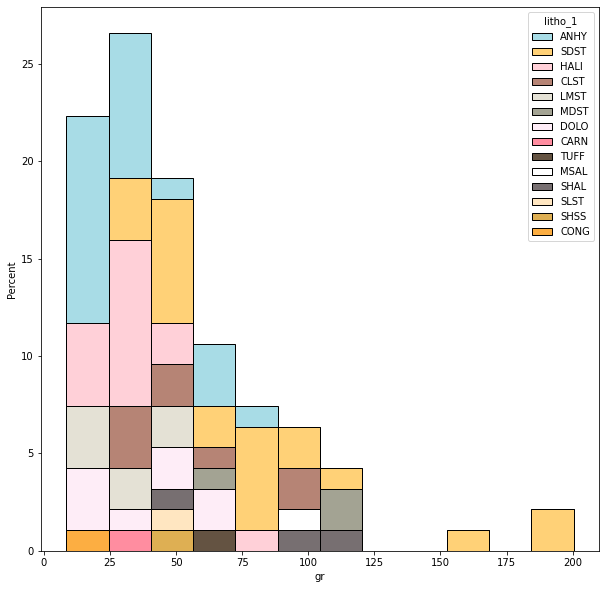

In [180]:
palette_l ={
    "ANHY": "#8bd1de", 
    "CARN": "#ff6780", 
    "HALI": "#ffc1cb",
    "MSAL": "#ffffff",
    "POLY": "#ff1f44 ", 
    "PSAL": "#ff6781", 
    "SYLV": "#ff6781",
    "GYPS": "#eeede4",
    "EVAP": "#d1edf2",
    "DOLO": "#fee8f5",
    "LMST": "#dcd8c7",
    "MDST": "#84846f",
    "CLST": "#9E5B47",
    "SHAL": "#4a3f41",
    "SHSS": "#d39519",
    "SLST": "#FFDEAD",
    "SDST": "#FFC249",
    "TUFF": "#301A03",
    "CONG": "#fc9303"
}

fig, axs = plt.subplots(figsize=(10,10))
gr_hist = sb.histplot(litho1_no_nans_df, x="gr", hue="litho_1", multiple="stack", ax=axs, stat="percent", palette=palette_l, legend=True)

# # dtco_hist = sb.histplot(litho1_no_nans_df, x="dtco", hue="litho_1", multiple="stack", ax=axs[0, 1], stat="percent", legend=False)
# # rhob_hist = sb.histplot(litho1_no_nans_df, x="rhob", hue="litho_1", multiple="stack", ax=axs[1, 0], stat="percent", legend=False)
# # drho_hist = sb.histplot(litho1_no_nans_df, x="drho", hue="litho_1", multiple="stack", ax=axs[1, 1], stat="percent", legend=False) 
# # nphi_hist = sb.histplot(litho1_no_nans_df, x="nphi", hue="litho_1", multiple="stack", ax=axs[2, 0], stat="percent", legend=False) 
# # pef_hist = sb.histplot(litho1_no_nans_df, x="pef", hue="litho_1", multiple="stack", ax=axs[2, 1], stat="percent", legend=True)
plt.show()

In [127]:
l.get_label()

''

In [13]:
well = "39/11- 1"
pd.set_option("display.max_row", 10)
x = sliced_logs.loc[(sliced_logs["well_name"] == well) & (sliced_logs["nphi"] > 0)]
print(x.shape, "    ", x.max())
x

(0, 9)      Unnamed: 0    NaN
well_name     NaN
md_in_m       NaN
gr            NaN
dtco          NaN
dtsh          NaN
rhob          NaN
nphi          NaN
md_round2     NaN
dtype: object


,Unnamed: 0,well_name,md_in_m,gr,dtco,dtsh,rhob,nphi,md_round2


In [14]:
sliced_logs[sliced_logs["well_name"] == well]

,Unnamed: 0,well_name,md_in_m,gr,dtco,dtsh,rhob,nphi,md_round2
100872,100872,39/11- 1,2632.9111,24.2851,66.4628,NaN,NaN,NaN,2632.91
100873,100873,39/11- 1,2633.0634,23.2254,60.8180,NaN,NaN,NaN,2633.06
100874,100874,39/11- 1,2633.2160,23.1656,57.8239,NaN,NaN,NaN,2633.22
100875,100875,39/11- 1,2633.3684,23.5197,57.4472,NaN,NaN,NaN,2633.37
100876,100876,39/11- 1,2633.5207,22.4991,59.0752,NaN,NaN,NaN,2633.52
...,...,...,...,...,...,...,...,...,...
101691,101691,39/11- 1,2757.7268,27.8079,65.6389,NaN,NaN,NaN,2757.73
101692,101692,39/11- 1,2757.8791,28.3627,65.1772,NaN,NaN,NaN,2757.88
101693,101693,39/11- 1,2758.0314,28.8106,65.5089,NaN,NaN,NaN,2758.03
101694,101694,39/11- 1,2758.1840,28.9700,66.5535,NaN,NaN,NaN,2758.18


<module 'dgbpy' from 'C:\\PROGRA~1\\OPENDT~1\\6683E8~1.0\\bin\\python\\dgbpy\\__init__.py'>

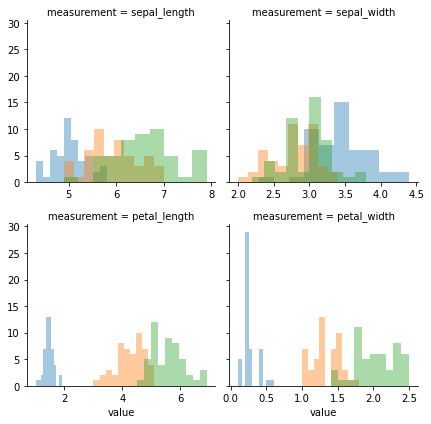

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

iris = sns.load_dataset("iris")
iris_long = pd.melt(iris, "species", var_name="measurement")
g = sns.FacetGrid(iris_long, hue="species", col="measurement", col_wrap=2, sharex=False)
g.map(plt.hist, "value", alpha=.4)

In [73]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


C:\Users\Monster\AppData\Local\Temp/ipykernel_8860/3631358060.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lst1)
C:\Users\Monster\AppData\Local\Temp/ipykernel_8860/3631358060.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lst1)


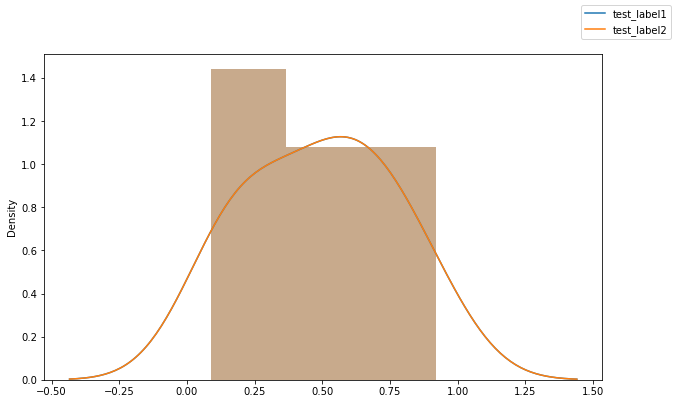

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
lst1 = list(np.random.rand(10))
lst2 = list(np.random.rand(10))
sns.distplot(lst1)
sns.distplot(lst1)
fig.legend(labels=['test_label1','test_label2'])
plt.show()

AttributeError: 'NoneType' object has no attribute 'legendHandles'

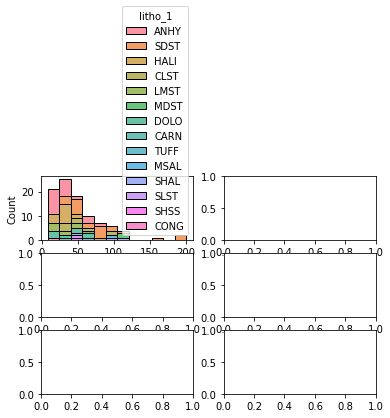

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df_dn = pd.DataFrame({'ktau': np.random.randn(4000).cumsum(),
                      'statind': np.repeat([*'abcd'], 1000)})

fig, axs = plt.subplots(3,2)
sp1 = sns.histplot(litho1_no_nans_df, x="gr", hue="litho_1",
                    multiple="stack", fill=True, ax=axs[0,0])
# ax1.set_title(r'$d_n$')
# ax1.set_xlabel(r'max($F_{a,max}$)')
# ax1.set_ylabel(r'$\tau_{ken}$')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
axs.legend(handles, sliced_litho["litho_1"], title='litho_1')
plt.show()